### Single Object Detection: IGrand Challenge

- Exploratory data analysis
- Data transformation for object detection
- Creating custom datasets
- Creating the model
- Defining the loss, optimizer, and IOU metric
- Training and evaluation of the model
- Deploying the model

In [5]:
import pandas as pd
import os

path2data = "./"

path2labels = "./Fovea_location.xlsx"


In [6]:
labels_df = pd.read_excel(path2labels, index_col='ID')

In [7]:
labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [8]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


<AxesSubplot:ylabel='Fovea_Y'>

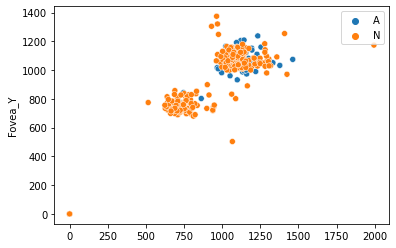

In [9]:
import seaborn as sns
%matplotlib inline

AorN = [inm[0] for inm in labels_df.imgName]
sns.scatterplot(x = labels_df.Fovea_X.values, y = labels_df.Fovea_Y, hue = AorN)

In [10]:
import collections
counter = collections.Counter(AorN)
print(counter)

Counter({'N': 311, 'A': 89})


In [11]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [12]:
plt.figure(figsize = (15,15))
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
nrows, ncols = 2,3
img_name = labels_df["imgName"]
ids = labels_df.index
rndIds = np.random.choice(ids, nrows*ncols)
print(rndIds)

[153 160 127  41  17  75]


<Figure size 1080x1080 with 0 Axes>

In [13]:
def load_img_label(labels_df, id_):
    imgName = labels_df["imgName"]
    if imgName[id_][0] == 'A':
        prefix = "AMD"
    else:
        prefix = "Non-AMD"
    path = os.path.join(path2data, "Training400", prefix, imgName[id_])
    
    img = Image.open(path)
    x = labels_df["Fovea_X"][id_]
    y = labels_df["Fovea_Y"][id_]
    label = (x,y)
    
    return img, label


In [16]:
def show_img_label(img,label, w_h = (50,50), thickness = 2):
    w,h = w_h
    cx, cy = label
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-(w/2), cy-(h/2)), (cx+(w/2), cy+(h/2))), outline = "green", width = thickness)
    plt.imshow(np.asarray(img))
    


(2124, 2056) (1055.07685255921, 1030.73766233766)
(1444, 1444) (639.360312038611, 814.762764100936)
(2124, 2056) (1049.20578478774, 1085.93174919748)
(2124, 2056) (1314.01019682664, 1059.75683052095)
(2124, 2056) (1226.23989848117, 1061.13181643457)
(2124, 2056) (1172.97048128342, 1082.46385026738)


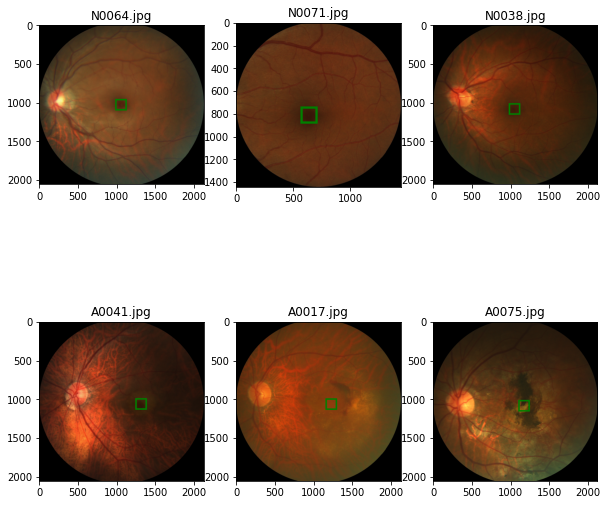

In [17]:
plt.figure(figsize=(10,10))
for i, id_ in enumerate(rndIds):
    img, labels = load_img_label(labels_df, id_)
    print(img.size, labels)
    plt.subplot(nrows, ncols, i+1)
    show_img_label(img, labels, w_h = (150,150), thickness=20)
    img_name = labels_df['imgName']
    plt.title(img_name[id_])

In [18]:
h_list, w_list = [], []

for i in labels_df.imgName:
    if i[0] == 'A':
        prefix = 'AMD'
    else:
        prefix = 'Non-AMD'
    path = os.path.join(path2data, "Training400", prefix, i)
    
    img = Image.open(path)
    h,w = img.size
    h_list.append(h)
    w_list.append(w)

Text(0.5, 1.0, 'Height')

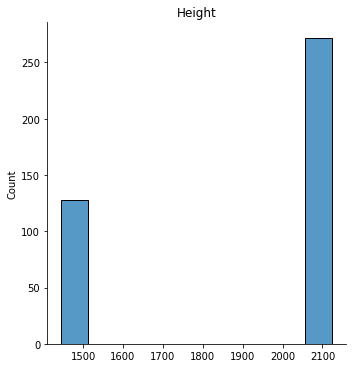

In [19]:
sns.displot(h_list)
plt.title('Height')

Text(0.5, 1.0, 'Width')

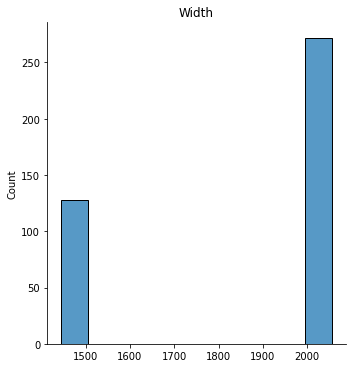

In [20]:
sns.displot(w_list)
plt.title('Width')

## Data Transformation

In [21]:
import torchvision.transforms.functional as TF

def resize_img_label(image, label = (0.0,0.0), target_size = (256,256)):
    w_orig, h_orig = image.size
    w_target, h_target = target_size
    cx,cy = label
    image_new = TF.resize(image,target_size)
    label_new = cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new, label_new

(2124, 2056) (1172.97048128342, 1082.46385026738)
(256, 256) (141.3749732620318, 134.7814910838761)


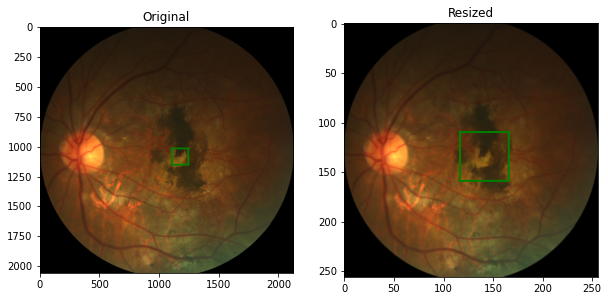

In [22]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(150,150), thickness=15)


plt.subplot(1,2,2)
plt.title('Resized')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)

In [23]:
def random_vflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.vflip(image)
    label = x, h-y
    
    return image, label


(2124, 2056) (1172.97048128342, 1082.46385026738)
(256, 256) (141.3749732620318, 134.7814910838761)


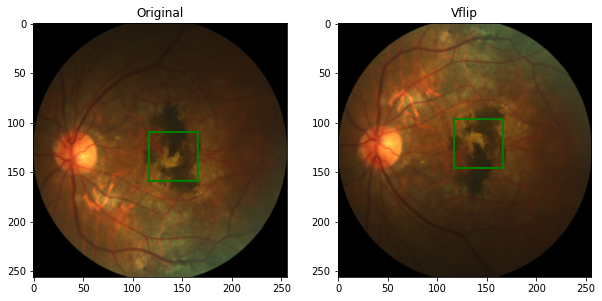

In [24]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Vflip')
img_v, label_v = random_vflip(img_r, label_r)
show_img_label(img_v,label_v, w_h=(50,50), thickness=2)

In [25]:
def random_hflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.hflip(image)
    label = w-x, y
    
    return image, label


(2124, 2056) (1172.97048128342, 1082.46385026738)
(256, 256) (141.3749732620318, 134.7814910838761)


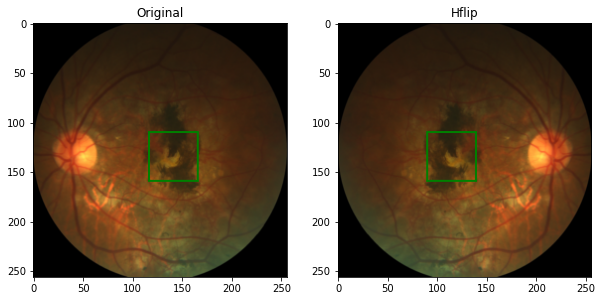

In [26]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Hflip')
img_h, label_h = random_hflip(img_r, label_r)
show_img_label(img_h,label_h, w_h=(50,50), thickness=2)

In [27]:
import numpy as np
np.random.seed(1)

def random_shift(image, label, max_translate = (0.2,0.2)):
    w,h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand()*2-1
    w_t = int(max_t_w*trans_coef*w)
    h_t = int(max_t_h*trans_coef*h)
    
    image = TF.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1)
    
    label = (cx + w_t, cy+h_t)
    
    return image, label
    
    
    

(2124, 2056) (1172.97048128342, 1082.46385026738)
(256, 256) (141.3749732620318, 134.7814910838761)


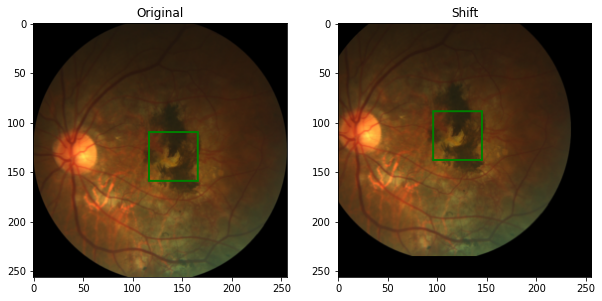

In [28]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Shift')
img_s, label_s = random_shift(img_r, label_r, max_translate=(.5,.5))
show_img_label(img_s,label_s)

### Custom Transformer

In [29]:
import random

In [30]:
def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image,label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image,label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image,label, params["max_translate"])
    image = TF.to_tensor(image)
    return image, label

In [31]:
params = {
    "target_size": (256,256),
    "p_hflip": 1.0,
    "p_vflip":1.0, 
    "p_shift":1.0,
    "max_translate": (0.2,0.2)
}

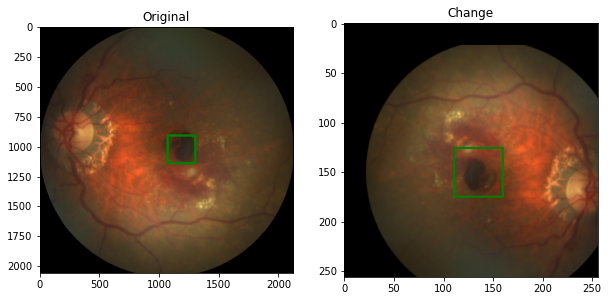

In [32]:
img, label = load_img_label(labels_df, 1)

img_t, label_t = transformer(img, label, params)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(250,250), thickness=20)
2
plt.subplot(1,2,2)
plt.title('Change')
show_img_label(TF.to_pil_image(img_t),label_t)

In [33]:
#Adding Brightness, contrast, gamma correction to prev transformer
# We also define scale label to limit them in (0,1)

def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image,label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image,label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image,label, params["max_translate"])
    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image = TF.adjust_brightness(image, brightness_factor)
    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image = TF.adjust_contrast(image, contrast_factor)
    if random.random() < params["p_gamma"]:
        gamma = 1+(np.random.rand()*2-1)*params["gamma"]
        image = TF.adjust_gamma(image, gamma)
    if params["scale_label"]:
        label = scale_label(label, params['target_size'])   
    
    image = TF.to_tensor(image)
    return image, label



In [34]:
params = {
    "target_size": (256,256),
    "p_hflip": 1.0,
    "p_vflip":1.0, 
    "p_shift":1.0,
    "max_translate": (0.2,0.2),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False
}

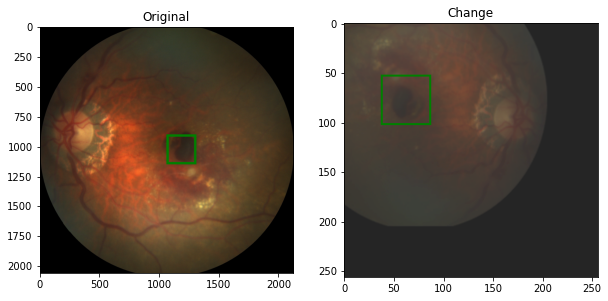

In [35]:
img, label = load_img_label(labels_df, 1)

img_t, label_t = transformer(img, label, params)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(250,250), thickness=20)
2
plt.subplot(1,2,2)
plt.title('Change')
show_img_label(TF.to_pil_image(img_t),label_t)

In [36]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

### Creating Custom Dataset

In [37]:
from torch.utils.data import Dataset
from PIL import Image

In [38]:
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_param):
        path2label = "./Fovea_location.xlsx"
        labels_df = pd.read_excel(path2label)
        self.labels = labels_df[["Fovea_X", "Fovea_Y"]].values
        
        self.imgName = labels_df["imgName"]
        self.ids = labels_df.index
        
        self.fullPath2img = []
        
        for id_ in self.ids:
            if self.imgName[id_][0] == 'A':
                prefix = 'AMD'
            else:
                prefix = 'Non-AMD'
            
            self.fullPath2img.append(os.path.join(path2data, "Training400", prefix, self.imgName[id_]))
        
        self.transform = transform
        self.trans_params = trans_param
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        image = Image.open(self.fullPath2img[idx])
        label = self.labels[idx]
        image, label = self.transform(image, label, self.trans_params)
        
        return image, label
    
    
        

In [39]:
trans_params_train={
"target_size" : (256, 256),
"p_hflip" : 0.5,
"p_vflip" : 0.5,
"p_shift" : 0.5,
"max_translate": (0.2, 0.2),
"p_brightness": 0.5,
"brightness_factor": 0.2,
"p_contrast": 0.5,
"contrast_factor": 0.2,
"p_gamma": 0.5,
"gamma": 0.2,
"scale_label": True,
}

trans_params_val={
"target_size" : (256, 256),
"p_hflip" : 0.0,
"p_vflip" : 0.0,
"p_shift" : 0.0,
"p_brightness": 0.0,
"p_contrast": 0.0,
"p_gamma": 0.0,
"gamma": 0.0,
"scale_label": True,
}



In [40]:
amd_ds1 = AMD_dataset(path2data, transformer, trans_params_train)
amd_ds2 = AMD_dataset(path2data, transformer, trans_params_val)

In [41]:
for x, y in amd_ds1:
    print(x.shape)
    print(y)
    break

torch.Size([3, 256, 256])
[0.31837840038124765, 0.3779091237409825]


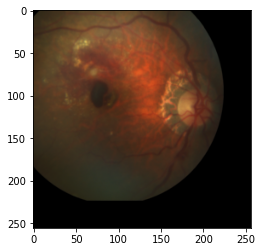

In [42]:
plt.imshow(x.numpy().transpose((1,2,0)))

In [43]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)

indices = range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

320
----------
80


In [44]:
from torch.utils.data import Subset
train_ds=Subset(amd_ds1,train_index)
print(len(train_ds))
val_ds=Subset(amd_ds2,val_index)
print(len(val_ds))

320
80


In [46]:
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label=rescale_label(label,img.shape[1:])
        x,y=label
        plt.plot(x,y,'b+',markersize=20)

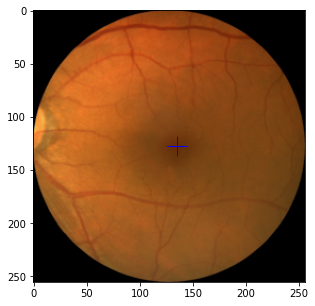

In [48]:
plt.figure(figsize=(5,5))
for img,label in train_ds:
    show(img,label)
    break

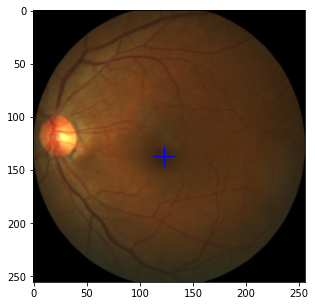

In [47]:
plt.figure(figsize=(5,5))
for img,label in val_ds:
    show(img,label)
    break

In [50]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size= 8, shuffle = True)

val_dl = DataLoader(val_ds, batch_size= 16, shuffle = False)